In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import sys

# Data Preparation

In [18]:
def prepare_data(path, split_ratio, seed):
    print("Data preparation has started.")
    np.random.seed(seed)
    print("Data import has started")
    try :
        df = pd.read_csv(path)
    except:
        print("Data file could not be found in given path. Please be sure the file exists in given path.")
        raise      
    else:
        data = df.to_numpy().astype(np.float32)
        print("Data import has finished")
        np.random.shuffle(data)
        X = data[:,1:]
        Y = data[:,0]
        splitPoint = round( len(Y)*split_ratio )
        train_x, train_y, test_x, test_y = X[:splitPoint], Y[:splitPoint], X[splitPoint:], Y[splitPoint:]
        print(f"Data has been splited according to ratio of {split_ratio}")
    
        print("Normalization has started")
        train_x /= 255.0
        test_x /= 255.0
        print("Completed")
        
        print("\nThe shapes of data is as following: ")
        print(f"Shape of train set of X is : {train_x.shape}")
        print(f"Shape of train set of Y is : {train_y.shape}")
        print(f"Shape of test set of X is : {test_x.shape}")
        print(f"Shape of test set of Y is: {test_y.shape}\n")
        
        return train_x, train_y, test_x, test_y

In [ ]:
def prepreparation(data):
    np.random.shuffle(data)
    X = data[:,1:]
    Y = data[:,0]
    splitPoint = round( len(Y)*split_ratio )
    train_x, train_y, test_x, test_y = X[:splitPoint], Y[:splitPoint], X[splitPoint:], Y[splitPoint:]
    print(f"Data has been splited according to ratio of {split_ratio}")
    
    print("Normalization has started")
    train_x /= 255.0
    test_x /= 255.0
    print("Completed")
        
    print("\nThe shapes of data is as following: ")
    print(f"Shape of train set of X is : {train_x.shape}")
    print(f"Shape of train set of Y is : {train_y.shape}")
    print(f"Shape of test set of X is : {test_x.shape}")
    print(f"Shape of test set of Y is: {test_y.shape}\n")
        
    return train_x, train_y, test_x, test_y

# TRAINING

In [6]:
def indicatorMatrix(y):
    N = len(y)
    y = y.astype(np.int32)
    K = y.max() + 1
    ind = np.zeros((N,K))
    for n in range(N):
        k = y[n]
        ind[n,k] = 1
    return ind

In [129]:
def forwardPropagation(X,W,b):
    Z = X.dot(W) + b
    expZ = np.exp(Z)
    return expZ / expZ.sum(axis = 1, keepdims = True)

In [84]:
def cost(p_y, t):
    tot = t * np.log(p_y)
    return -tot.sum()

In [9]:
def error_rate(p_y, t):
    prediction = predict(p_y)
    return np.mean(prediction != t)

In [10]:
def predict(p_y):
    return np.argmax(p_y, axis = 1)

In [11]:
def gradW(t, y, X):
    return X.T.dot(t - y)
def gradb(t, y):
    return (t - y).sum(axis = 0)

In [118]:
def getBatches(X,Y,batch_size):
    if batch_size == -1:
        batch_size = len(Y)
        
    batch_number = int(np.ceil( len(Y) / batch_size ))
    Xb, Yb = [None]*batch_number, [None]*batch_number
    for i in range(batch_number):
        Xb[i] = X[i*batch_size : (i+1)*batch_size ]
        Yb[i] = Y[i*batch_size : (i+1)*batch_size ]
        if i == batch_number - 1:
            print(f"Batched is finished")
    return Xb, Yb

In [124]:
def linearModel(path, split_ratio, seed, batch_size, learning_rate = 0.0001, regularization = 0.0, n_iter = 100):
    
    train_x, train_y, test_x, test_y = prepare_data(path, split_ratio, seed)
    
    M, NX = train_x.shape
    train_indicatorMatrix = indicatorMatrix(train_y)
    K = train_indicatorMatrix.shape[1]
    print(f"Target number is {K}")
    print(f"Train ind matrix is : {train_indicatorMatrix.shape}")
    
    print("Initialization of weight matrix and bias vector has started...\n")
    W = np.random.randn(NX,K) / np.sqrt(NX)
    print(f"Shape of W is {W.shape}")
    b = np.zeros(K)
    print(f"Shape of b is {b.shape}")
    print("\nInitialization of weight matrix and bias vector has COMPLETED\n")
    
    train_losses, test_losses, train_error, test_error = [],[],[],[]
    
    print("Training has started.\n")
    
    if batch_size == -1:
        print(f"Full Gradient Descent has chosen by user.")
    elif batch_size == 1:
        print(f"Stocastic Gradient Descent has chosen by user.")
    else:
        print(f"Mini-Batch Gradient Descent has chosen by user.")
        
    for i in range(n_iter):
        
        if batch_size != -1:
            
            permutation = np.random.permutation(len(train_x))            
            train_x, train_y = train_x[permutation], train_y[permutation]
            train_indicatorMatrix = indicatorMatrix(train_y)
            
        Xb, Yb = getBatches(train_x, train_y, batch_size)
        
        for X, Y in zip(Xb, Yb):
            
            if batch_size != -1:
                train_indicatorMatrix_batch = train_indicatorMatrix[i*len(X):(i+1)*len(X)]
            else :
                train_indicatorMatrix_batch = train_indicatorMatrix
                
            p_y = forwardPropagation(X, W, b)
            trainLoss = cost(p_y, train_indicatorMatrix_batch)
            train_losses.append(trainLoss)
            trainError = error_rate(p_y, Y)
            train_error.append(trainError)
            
            W += learning_rate*(gradW( train_indicatorMatrix_batch, p_y, X) - regularization*W)
            b += learning_rate*(gradb( train_indicatorMatrix_batch, p_y ))

             
        if (i+1)%10 == 0:
            print(f"Iteration : {i+1} Train Loss : {trainLoss:.3f} Train Error : {trainError:.3f}")
        
    p_y = forwardPropagation(test_x, W, b)
    test_indicatorMatrix = indicatorMatrix(test_y)
    
    print("Training has finished.\n")
    print(f"Final error rate is {error_rate(p_y, test_y)}")
    
    results = {
        "test_error_rate": error_rate(p_y, test_y),
        "test_cost": cost(p_y, test_indicatorMatrix),
        "costs": train_losses,
        "errors": train_error,
        "w" : W,
        "b" : b,
        "n_iter" : n_iter,
        "batch_size" : batch_size
    }
    
    return results

In [104]:
def plot_model(results):
    for c,result in enumerate(results):
        plt.plot(result["costs"], label = f"Cost of Model {c}")
        plt.suptitle(f"Batch size {result['batch_size']} and Iteration number {result['n_iter']}")
    plt.title("Loss per iteration")
    plt.legend()
    plt.show()
    
    for c,result in enumerate(results):
        plt.plot(result["errors"], label = f"Train Error of Model {c}")
    plt.title("Loss per iteration")
    plt.legend()
    plt.show()

In [96]:
res = linearModel("train.csv", 0.7, 10, 1, learning_rate = 0.0003, regularization = 0.0, n_iter = 10)

Data preparation has started.
Data import has started
Data import has finished
Data has been splited according to ratio of 0.7
Normalization has started
Completed

The shapes of data is as following: 
Shape of train set of X is : (29400, 784)
Shape of train set of Y is : (29400,)
Shape of test set of X is : (12600, 784)
Shape of test set of Y is: (12600,)

Target number is 10
Train ind matrix is : (29400, 10)
Initialization of weight matrix and bias vector has started...

Shape of W is (784, 10)
Shape of b is (10,)

Initialization of weight matrix and bias vector has COMPLETED

Training has started.

Stocastic Gradient Descent has chosen by user.
Batched is finished
Batched is finished
Batched is finished
Batched is finished
Batched is finished
Batched is finished
Batched is finished
Batched is finished
Batched is finished
Batched is finished
Iteration : 10 Train Loss : 0.022 Train Error : 1.000
Training has finished.

Final error rate is 0.8990476190476191


In [127]:
res2 = linearModel("train.csv", 0.7, 10, -1, learning_rate = 0.0003, regularization = 0.0, n_iter = 1000)

Data preparation has started.
Data import has started
Data import has finished
Data has been splited according to ratio of 0.7
Normalization has started
Completed

The shapes of data is as following: 
Shape of train set of X is : (29400, 784)
Shape of train set of Y is : (29400,)
Shape of test set of X is : (12600, 784)
Shape of test set of Y is: (12600,)

Target number is 10
Train ind matrix is : (29400, 10)
Initialization of weight matrix and bias vector has started...

Shape of W is (784, 10)
Shape of b is (10,)

Initialization of weight matrix and bias vector has COMPLETED

Training has started.

Full Gradient Descent has chosen by user.
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finish

Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Iteration : 180 Train Loss : 16908.351 Train Error : 0.080
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Iteration : 190 Train Loss : 15460.353 Train Error : 0.079
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Iteration : 200 Train Loss : 12

expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Iteration : 370 Train Loss : 20076.101 Train Error : 0.082
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Iteration : 380 Train Loss : 16713.548 Train Error : 0.074
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Iteration : 390 Train Loss : 15120.514 Train Error : 0.072
Batched is finished
expZ (294

expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Iteration : 570 Train Loss : 13517.417 Train Error : 0.069
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Iteration : 580 Train Loss : 17985.451 Train Error : 0.092
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is fin

expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Iteration : 760 Train Loss : 13375.474 Train Error : 0.066
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Iteration : 770 Train Loss : 12616.247 Train Error : 0.066
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is fin

expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Iteration : 950 Train Loss : 86321.471 Train Error : 0.234
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Iteration : 960 Train Loss : 16003.095 Train Error : 0.072
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is finished
expZ (29400, 10)
Batched is fin

In [128]:
res3 = linearModel("train.csv", 0.7, 10, 1000, learning_rate = 0.0003, regularization = 0.0, n_iter = 1000)

Data preparation has started.
Data import has started
Data import has finished
Data has been splited according to ratio of 0.7
Normalization has started
Completed

The shapes of data is as following: 
Shape of train set of X is : (29400, 784)
Shape of train set of Y is : (29400,)
Shape of test set of X is : (12600, 784)
Shape of test set of Y is: (12600,)

Target number is 10
Train ind matrix is : (29400, 10)
Initialization of weight matrix and bias vector has started...

Shape of W is (784, 10)
Shape of b is (10,)

Initialization of weight matrix and bias vector has COMPLETED

Training has started.

Mini-Batch Gradient Descent has chosen by user.
Batched is finished
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ

expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (400, 10)
Batched is finished
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (1000, 10)
expZ (400, 10)
Batched is finished
ex

ValueError: operands could not be broadcast together with shapes (400,10) (1000,10) 

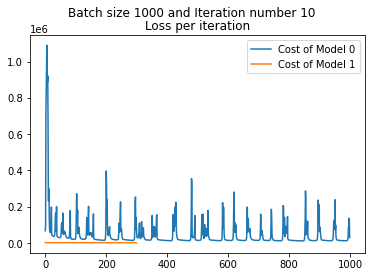

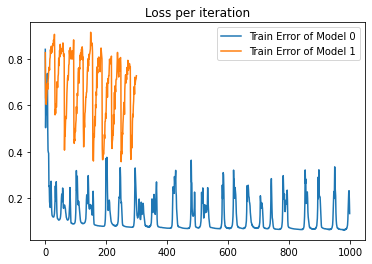

In [132]:
results = []
#results.append(res)
results.append(res2)
results.append(res3)
plot_model(results)